In [130]:
!pip install folium
import folium
import pandas as pd
import requests  
import numpy as np
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
!pip install kmeans
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

# WHERE TO OPEN A CRAFT BEER BAR IN PARIS?

## Using data science to find the best location

# Introduction:

## Background

The craft beer movement, a trend imported from the United States, is spreading all around Europe and is growing steadily in France, originally considered as a wine country. The insatiable demand for quality craft beer led to the creation of more and more microbreweries and beer bars specialized in craft beer over the past 15 years.

## Goals

Through data science, the following analysis tries to define the most favorable districts to establish a craft beer bar in Paris, France. Using data analysis, data visualization and machine learning, we will narrow down neighborhoods in Paris based on different criteria:

First, we want our bar to be located in an attractive and vibrant area of Paris, with an active nightlife. The presence of other nearby venues will attract people and create traffic. On the other hand, as our concept represents a niche (craft beer lovers), we want to avoid the presence of direct competitors in the same neighborhood. At last, Paris is a very expensive city and the exorbitant real estate prices can be a barrier to entry for opening a business. Thus, we will focus on neighborhoods whose prices match our budget.

This analysis represents a draft market study for a business plan or an executive summary. It is intended for potential entrepreneurs who want to better understand the market of craft beer pubs in Paris by providing a data-driven insight into the best locations, based on specific criteria.


# Data:

Paris is divided in 20 boroughs called “Arrondissements” and 80 neighborhoods. Data about boroughs and neighborhoods is available online. It can be found for free at https://www.data.gouv.fr/fr/datasets/quartiers-administratifs/ and https://datafrance.info/paris-75000. We will be using geographical coordinates for each neighborhood, their name and average price per Square Meter.

To compare neighborhoods among each other’s, we will use the Foursquare API that list all venues in specific areas. We will then be able to cluster the neighborhoods based on their similarities using unsupervised machine learning technique to select the best fit for our craft beer pub.


## I. Collecting the data

The data used is collected from two sources : https://datafrance.info/paris-75000 and https://www.data.gouv.fr/fr/datasets/quartiers-administratifs/ in JSON files

After cleaning, the master data looks like this: 

In [131]:
df=pd.read_csv('Paris_data.csv')
df

,Neighborhood,Arrondissement,Latitude,Longitude,Price
0,Place-Vendome,1,48.867019,2.328582,9816
1,Halles,1,48.862289,2.344899,9816
2,Palais-Royal,1,48.864660,2.336309,9816
3,Saint-Germain-l'Auxerrois,1,48.860650,2.334910,9816
4,Gaillon,2,48.869307,2.333432,11262
...,...,...,...,...,...
75,Amerique,19,48.881638,2.395440,7909
76,Charonne,20,48.854760,2.407430,7853
77,Saint-Fargeau,20,48.871035,2.406172,7853
78,Belleville,20,48.871531,2.387549,7853


It contains the necessary of information : Neighborhood, Borough, Latitude, Longitude and average square meter price.

Note that Paris is divided into 20 boroughs and 80 neighborhoods 

# II. Segmenting the data

## A- Creating a map of Paris and its neighborhoods

I used the geographical data of each neighborhood to visualize them on the map with the Folium library.

In [134]:
map_paris = folium.Map(location=[48.85889, 2.32004], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

## B- Using Foursquare API to get the venues:

We want our bar to be located in a good area with an active night life and similar venues around to attract customers. 

To explore and define the type of neighborhood, I use the Foursquare API to get all nearby venues around each neighborhood. I set the limit to 500 in a radius of 1km.

In [136]:
# My Foursquare credentials
CLIENT_ID = 'EA24PWBDYH1ZZQBWDRQEOGZVDDUEAYKHZ3OOTVGFP3CLRJ0T'
CLIENT_SECRET = 'FROZNBYP2JUVWRWEB2B0RLIL4UDMX30TEJWL25PBF421VTYC' 
VERSION = '20211005'
ACCESS_TOKEN = 'Z3G1ZAJAUNVEMK3R4VA41YMC5NCQZABT5TO1HZU2ZEOVP35R'

My credentials:
CLIENT_ID: EA24PWBDYH1ZZQBWDRQEOGZVDDUEAYKHZ3OOTVGFP3CLRJ0T
CLIENT_SECRET:FROZNBYP2JUVWRWEB2B0RLIL4UDMX30TEJWL25PBF421VTYC


In [137]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

In [138]:
LIMIT=500
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=EA24PWBDYH1ZZQBWDRQEOGZVDDUEAYKHZ3OOTVGFP3CLRJ0T&client_secret=FROZNBYP2JUVWRWEB2B0RLIL4UDMX30TEJWL25PBF421VTYC&v=20211005&ll=48.8670185906,2.32858166493&radius=1000&limit=500'

In [139]:
 def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',]
    
    return(nearby_venues)

paris_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])
print(paris_venues.shape)
paris_venues.head()

Place-Vendome
Halles
Palais-Royal
Saint-Germain-l'Auxerrois
Gaillon
Mail
Bonne-Nouvelle
Vivienne
Archives
Sainte-Avoie
Arts-et-Metiers
Enfants-Rouges
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Jardin-des-Plantes
Val-de-Grace
Sorbonne
Saint-Victor
Saint-Germain-des-Pres
Odeon
Notre-Dame-des-Champs
Monnaie
Invalides
Ecole-Militaire
Gros-Caillou
Saint-Thomas-d'Aquin
Champs-Elysees
Europe
Faubourg-du-Roule
Madeleine
Saint-Georges
Faubourg-Montmartre
Chaussee-d'Antin
Rochechouart
Hopital-Saint-Louis
Porte-Saint-Denis
Saint-Vincent-de-Paul
Porte-Saint-Martin
Folie-Mericourt
Sainte-Marguerite
Saint-Ambroise
Roquette
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpetriere
Croulebarbe
Maison-Blanche
Gare
Parc-de-Montsouris
Plaisance
Petit-Montrouge
Montparnasse
Necker
Grenelle
Javel
Saint-Lambert
Muette
Porte-Dauphine
Auteuil
Chaillot
Epinettes
Plaine de Monceaux
Ternes
Batignolles
Grandes-Carrieres
La Chapelle
Goutte-d'Or
Clignancourt
Combat
Villette
Pont-de-Flandre
Amerique
Charonne
Saint-Fargeau
Be

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Place-Vendome,48.867019,2.328582,Hôtel Ritz,48.868106,2.328892,Hotel
1,Place-Vendome,48.867019,2.328582,Place Vendôme,48.867798,2.329741,Plaza
2,Place-Vendome,48.867019,2.328582,Hôtel Mandarin Oriental,48.866987,2.327178,Hotel
3,Place-Vendome,48.867019,2.328582,Charvet,48.868312,2.330282,Men's Store
4,Place-Vendome,48.867019,2.328582,Ladurée,48.866121,2.328449,Dessert Shop


In [140]:
print('There are {} uniques venues categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 300 uniques venues categories.


I put all the venues into a dataframe. We notice that the table has 5034 rows which means that the Foursquare request found 5034 nearby venues with 300 uniques venues categories

## C- Creating a new dataframe with the top 10 venues for each neighborhood

In [143]:
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amerique,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.000000,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0
1,Archives,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.04,...,0.010000,0.0,0.0,0.00,0.010000,0.00,0.0,0.0,0.0,0.0
2,Arsenal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.029412,0.0,0.0,0.00,0.014706,0.00,0.0,0.0,0.0,0.0
3,Arts-et-Metiers,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.02,...,0.010000,0.0,0.0,0.03,0.050000,0.02,0.0,0.0,0.0,0.0
4,Auteuil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.000000,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0


In [145]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amerique,Supermarket,Plaza,French Restaurant,Café,Bistro,Park,Bed & Breakfast,Smoke Shop,Health Food Store,Pool
1,Archives,French Restaurant,Hotel,Coffee Shop,Italian Restaurant,Bar,Art Gallery,Tapas Restaurant,Japanese Restaurant,Cocktail Bar,Historic Site
2,Arsenal,French Restaurant,Hotel,Plaza,Park,Thai Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Pedestrian Plaza,Boat or Ferry,Italian Restaurant
3,Arts-et-Metiers,French Restaurant,Hotel,Wine Bar,Cocktail Bar,Chinese Restaurant,Italian Restaurant,Restaurant,Vietnamese Restaurant,Japanese Restaurant,Coffee Shop
4,Auteuil,Tennis Court,Stadium,Sporting Goods Shop,Outdoors & Recreation,Office,French Restaurant,Botanical Garden,Museum,Garden,Racecourse


In this table, we discover the 10 most common venues for each neighborhood. This already gives us some insight about the type of neighborhood and if it can be a good fit for a craft beer bar. 

# III. Clustering similar neighborhoods using K-means

Now that we know some characteristics of Parisian neighborhoods, we can create clusters based on their similarities using an unsupervised machine learning tool called K-means. 

## A- Defining the best number of clusters 

To define the most appropriate number of clusters, I use the silhouette score. 

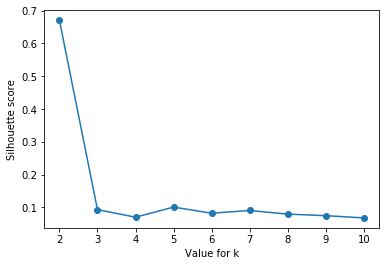

[0.6703332772728113,
 0.09315676549532688,
 0.07003878919537702,
 0.10078652322240096,
 0.08215534977796261,
 0.09043153817564309,
 0.07935659584099615,
 0.0746803396729476,
 0.067812643369896]

In [148]:
paris_cluster = paris_grouped.drop('Neighborhood', 1)

k = [2, 3, 4, 5, 6, 7, 8, 9, 10]

sil=[]

for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster).fit(paris_cluster)
    silhouette_avg = silhouette_score(paris_cluster, kmeans.labels_)
    sil.append(silhouette_score(paris_cluster, kmeans.labels_))

plt.plot(k, sil, 'o-')
plt.xlabel("Value for k")
plt.ylabel("Silhouette score")
plt.show()
sil

The best number of clusters is 6

## B. Clustering the neighborhoods in Paris

K-Means will assign each neighborhood to a cluster. I added the cluster label in a new column of the dataframe. 

In [151]:
kclusters = 6
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = df
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
paris_merged=paris_merged.astype({"Cluster Labels": int})
paris_merged.head()

,Neighborhood,Arrondissement,Latitude,Longitude,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Place-Vendome,1,48.867019,2.328582,9816,1,Hotel,French Restaurant,Jewelry Store,Japanese Restaurant,Boutique,Chocolate Shop,Plaza,Hotel Bar,Bookstore,Accessories Store
1,Halles,1,48.862289,2.344899,9816,2,French Restaurant,Bakery,Coffee Shop,Sandwich Place,Pedestrian Plaza,Spa,Ice Cream Shop,Tea Room,Art Gallery,Chinese Restaurant
2,Palais-Royal,1,48.864660,2.336309,9816,1,Japanese Restaurant,French Restaurant,Hotel,Italian Restaurant,Plaza,Bookstore,Historic Site,Café,Wine Bar,Bakery
3,Saint-Germain-l'Auxerrois,1,48.860650,2.334910,9816,1,French Restaurant,Hotel,Plaza,Historic Site,Italian Restaurant,Art Museum,Coffee Shop,Dessert Shop,Cosmetics Shop,Pedestrian Plaza
4,Gaillon,2,48.869307,2.333432,11262,1,Japanese Restaurant,Hotel,French Restaurant,Wine Bar,Theater,Italian Restaurant,Chocolate Shop,Bookstore,Jewelry Store,Udon Restaurant


Now it's time to visualize the 6 differents clusters on the map, using Folium.

In [152]:
# create map
map_clusters = folium.Map(location=[48.8534, 2.3488], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Neighborhoods are grouped into 6 clusters based on their characteristics. 

To open our beer bar, we are looking for an active location, where people go out. So let's analyze each clusters :

### Cluster 1 (red) : Mainly restaurants. 

In [155]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Arsenal,0,French Restaurant,Hotel,Plaza,Park,Thai Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Pedestrian Plaza,Boat or Ferry,Italian Restaurant
19,Saint-Victor,0,French Restaurant,Bakery,Hotel,Bistro,Park,Italian Restaurant,Japanese Restaurant,Museum,Pub,Wine Bar
22,Notre-Dame-des-Champs,0,French Restaurant,Hotel,Bakery,Japanese Restaurant,Bistro,Italian Restaurant,Creperie,Steakhouse,Bagel Shop,Ice Cream Shop
24,Invalides,0,French Restaurant,Hotel,Plaza,Bistro,History Museum,Café,Art Museum,Italian Restaurant,Park,Tea Room
25,Ecole-Militaire,0,Hotel,French Restaurant,Plaza,Farmers Market,Café,Bistro,Pastry Shop,Asian Restaurant,Garden,Dessert Shop
26,Gros-Caillou,0,French Restaurant,Italian Restaurant,Hotel,Café,Ice Cream Shop,Bakery,Coffee Shop,Bistro,Garden,Dessert Shop
27,Saint-Thomas-d'Aquin,0,French Restaurant,Hotel,Café,Bakery,Coffee Shop,Italian Restaurant,Tailor Shop,Historic Site,Art Gallery,Shoe Store
29,Europe,0,French Restaurant,Hotel,Pizza Place,Sandwich Place,Wine Shop,Bistro,Thai Restaurant,Mobile Phone Shop,Mediterranean Restaurant,Men's Store
33,Faubourg-Montmartre,0,French Restaurant,Hotel,Italian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Restaurant,Pedestrian Plaza,Pizza Place,Brazilian Restaurant
35,Rochechouart,0,French Restaurant,Hotel,Bakery,Pizza Place,Vegetarian / Vegan Restaurant,Wine Bar,Vietnamese Restaurant,Restaurant,Italian Restaurant,Coffee Shop


###  Cluster 2 (purple): Mainly hotels.

In [157]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Place-Vendome,1,Hotel,French Restaurant,Jewelry Store,Japanese Restaurant,Boutique,Chocolate Shop,Plaza,Hotel Bar,Bookstore,Accessories Store
2,Palais-Royal,1,Japanese Restaurant,French Restaurant,Hotel,Italian Restaurant,Plaza,Bookstore,Historic Site,Café,Wine Bar,Bakery
3,Saint-Germain-l'Auxerrois,1,French Restaurant,Hotel,Plaza,Historic Site,Italian Restaurant,Art Museum,Coffee Shop,Dessert Shop,Cosmetics Shop,Pedestrian Plaza
4,Gaillon,1,Japanese Restaurant,Hotel,French Restaurant,Wine Bar,Theater,Italian Restaurant,Chocolate Shop,Bookstore,Jewelry Store,Udon Restaurant
11,Enfants-Rouges,1,Hotel,French Restaurant,Wine Bar,Japanese Restaurant,Sandwich Place,Cocktail Bar,Art Gallery,Vietnamese Restaurant,Bar,Italian Restaurant
16,Jardin-des-Plantes,1,French Restaurant,Science Museum,Hotel,Garden,Zoo Exhibit,Greek Restaurant,Coffee Shop,Plaza,Bakery,Botanical Garden
18,Sorbonne,1,French Restaurant,Hotel,Plaza,Indie Movie Theater,Coffee Shop,Café,Ice Cream Shop,Bookstore,Bar,Bakery
20,Saint-Germain-des-Pres,1,French Restaurant,Hotel,Italian Restaurant,Plaza,Wine Bar,Sandwich Place,Pastry Shop,Café,Boutique,Bookstore
21,Odeon,1,Café,Hotel,French Restaurant,Bakery,Plaza,Fountain,Garden,Cocktail Bar,Bistro,Boutique
28,Champs-Elysees,1,French Restaurant,Hotel,Boutique,Italian Restaurant,Clothing Store,Japanese Restaurant,Garden,Art Gallery,Plaza,Steakhouse


###  Cluster 3 (blue): a lot of bars, restaurants and cafés.

In [159]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Halles,2,French Restaurant,Bakery,Coffee Shop,Sandwich Place,Pedestrian Plaza,Spa,Ice Cream Shop,Tea Room,Art Gallery,Chinese Restaurant
5,Mail,2,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Bar,Hotel,Salad Place,Coffee Shop,Thai Restaurant,Japanese Restaurant
6,Bonne-Nouvelle,2,Cocktail Bar,French Restaurant,Wine Bar,Japanese Restaurant,Hotel,Bakery,Italian Restaurant,Restaurant,Chinese Restaurant,Tea Room
7,Vivienne,2,French Restaurant,Hotel,Japanese Restaurant,Wine Bar,Bakery,Coffee Shop,Bookstore,Salad Place,Udon Restaurant,Bistro
8,Archives,2,French Restaurant,Hotel,Coffee Shop,Italian Restaurant,Bar,Art Gallery,Tapas Restaurant,Japanese Restaurant,Cocktail Bar,Historic Site
9,Sainte-Avoie,2,French Restaurant,Art Gallery,Hotel,Café,Restaurant,Chinese Restaurant,Bakery,Wine Bar,Vietnamese Restaurant,Italian Restaurant
10,Arts-et-Metiers,2,French Restaurant,Hotel,Wine Bar,Cocktail Bar,Chinese Restaurant,Italian Restaurant,Restaurant,Vietnamese Restaurant,Japanese Restaurant,Coffee Shop
12,Saint-Merri,2,French Restaurant,Ice Cream Shop,Art Gallery,Pastry Shop,Plaza,Bookstore,Bakery,Pedestrian Plaza,Gourmet Shop,Coffee Shop
13,Saint-Gervais,2,French Restaurant,Clothing Store,Pastry Shop,Hotel,Italian Restaurant,Ice Cream Shop,Plaza,Pedestrian Plaza,Wine Bar,Gourmet Shop
15,Notre-Dame,2,French Restaurant,Plaza,Italian Restaurant,Japanese Restaurant,Ice Cream Shop,Wine Bar,Bakery,Tapas Restaurant,Hotel,Cupcake Shop


###  Cluster 4 (turquoise): not an interesting place for a bar.

In [161]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Porte-Dauphine,3,Park,Tennis Court,Pizza Place,Gym / Fitness Center,Grocery Store,Metro Station,Train Station,Pharmacy,Gym Pool,Plaza
62,Auteuil,3,Tennis Court,Stadium,Sporting Goods Shop,Outdoors & Recreation,Office,French Restaurant,Botanical Garden,Museum,Garden,Racecourse


###  Cluster 5 (green): not an interesting place for a bar.

In [163]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,Picpus,4,Locksmith,Pastry Shop,Organic Grocery,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Park,Outdoors & Recreation,Outdoor Sculpture,Accessories Store


###  Cluster 6 (orange): not an interesting place for a bar.

In [165]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Bel-Air,5,Recreation Center,French Restaurant,Playground,Café,Botanical Garden,Plaza,Sports Club,Office,Noodle House,Okonomiyaki Restaurant
50,Maison-Blanche,5,French Restaurant,Bakery,Café,Plaza,Pizza Place,Fast Food Restaurant,Bistro,Supermarket,Stadium,Beer Store
69,La Chapelle,5,Chinese Restaurant,French Restaurant,Soccer Field,Supermarket,Mexican Restaurant,Thai Restaurant,Garden,Farmers Market,Gym Pool,Asian Restaurant
70,Goutte-d'Or,5,Bar,Supermarket,Fast Food Restaurant,Chinese Restaurant,Asian Restaurant,Plaza,Café,Sushi Restaurant,French Restaurant,Health Food Store
75,Amerique,5,Supermarket,Plaza,French Restaurant,Café,Bistro,Park,Bed & Breakfast,Smoke Shop,Health Food Store,Pool
76,Charonne,5,Supermarket,Hotel,Tram Station,Bar,Pizza Place,Soccer Stadium,Bike Rental / Bike Share,Theater,Park,Brazilian Restaurant
77,Saint-Fargeau,5,Supermarket,Café,Plaza,Pool,Food Truck,Pizza Place,French Restaurant,Arts & Entertainment,Diner,Opera House


After analyzing each cluster, we can deduct that we want our bar to be in a neighborhood belonging to the cluster 1, 2 or 3. Those are the neighborhoods where we find numerous restaurants, bars, hotels and cafés. 

In [166]:
# We narrow down neighborhoods from cluster 1, 2, 3.  
c1=paris_merged.loc[paris_merged['Cluster Labels'] == 0]
c2=paris_merged.loc[paris_merged['Cluster Labels'] == 1]
c3=paris_merged.loc[paris_merged['Cluster Labels'] == 2]
c1c2=c1.append(c2, ignore_index=True)
good_clusters=c1c2.append(c3,ignore_index=True)
good_clusters
good_clusters.shape

(70, 16)

# IV. Selecting Neighborhoods based on their average square meter price

Now that we narrowed down neighborhoods based on the nearby venues, It is important to look at the average square meter price for each neighborhood. Some neighborhoods in Paris are extremely expensive. Let's get rid of locations where the average price is above 9,8k€ per m2 so it can match out budget.

In [168]:
good_price=good_clusters.loc[(good_clusters['Price'] < 9800)]
good_price


,Neighborhood,Arrondissement,Latitude,Longitude,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Sainte-Marguerite,11,48.852097,2.388765,9571,0,French Restaurant,Hotel,Italian Restaurant,Bistro,Bar,Beer Bar,Convenience Store,Thai Restaurant,Coffee Shop,Korean Restaurant
11,Montparnasse,14,48.837623,2.331784,9531,0,French Restaurant,Hotel,Bistro,Bar,Italian Restaurant,Bus Stop,Sushi Restaurant,Bakery,Restaurant,Café
12,Necker,15,48.842711,2.310777,9583,0,French Restaurant,Hotel,Café,Gym / Fitness Center,Dessert Shop,Vietnamese Restaurant,Bakery,Chinese Restaurant,Grocery Store,Pizza Place
13,Javel,15,48.839060,2.278076,9583,0,French Restaurant,Café,Sushi Restaurant,Japanese Restaurant,Pizza Place,Bistro,Thrift / Vintage Store,Moroccan Restaurant,Bike Rental / Bike Share,Supermarket
14,Saint-Lambert,15,48.834294,2.296920,9583,0,French Restaurant,Hotel,Bakery,Café,Plaza,Thai Restaurant,Italian Restaurant,Sports Bar,Chinese Restaurant,Farmers Market
20,Grandes-Carrieres,18,48.892578,2.334363,8874,0,French Restaurant,Bar,Restaurant,Hotel,Pizza Place,Thai Restaurant,Park,Italian Restaurant,Bistro,Beer Bar
21,Combat,19,48.878639,2.380127,7909,0,French Restaurant,Restaurant,Park,Italian Restaurant,Pool,Beer Garden,Hostel,Gas Station,Soup Place,Moroccan Restaurant
36,Porte-Saint-Denis,10,48.873618,2.352283,9441,1,Hotel,French Restaurant,Bistro,Japanese Restaurant,Bakery,Vegetarian / Vegan Restaurant,Pizza Place,Restaurant,Fast Food Restaurant,Indian Restaurant
37,Saint-Vincent-de-Paul,10,48.880735,2.357471,9441,1,Indian Restaurant,French Restaurant,Hotel,African Restaurant,Wine Shop,Italian Restaurant,Supermarket,Bistro,Food & Drink Shop,Theater
38,Bercy,12,48.835209,2.386210,8836,1,Hotel,Italian Restaurant,French Restaurant,Breakfast Spot,Bakery,Café,Museum,Supermarket,Bus Stop,Pastry Shop


I created a list of neighborhoods that belong to clusters 1, 2, 3 and that match our budget. We end up having 28 rows. 


# V. Droping neighborhoods with competitors

To avoid competing with another already established craft beer pub, we need to check which selected neighborhoods already have a Beer bar. 


In [170]:
good_onehot=paris_onehot.loc[paris_onehot['Neighborhood'].isin(['Pere-Lachaise','Belleville','Clignancourt','Croulebarbe','Quinze-Vingts','Roquette','Saint-Ambroise',
                                                    'Folie-Mericourt',
                                                    'Porte-Saint-Martin','Hopital-Saint-Louis','Pont-de-Flandre','Villette','Grenelle','Petit-Montrouge',
                                                    'Plaisance','Parc-de-Montsouris','Gare',
                                                   'Salpetriere','Bercy','Saint-Vincent-de-Paul','Porte-Saint-Denis','Combat','Grandes-Carrieres',
                                                    'Saint-Lambert','Javel','Necker','Montparnasse','Sainte-Marguerite'])]

In [194]:
paris_beer = good_onehot[['Neighborhood','Beer Bar']]

paris_beer = paris_beer.groupby(['Neighborhood']).sum()

paris_beer = paris_beer.reset_index()
paris_beer = paris_beer.sort_values(by=['Beer Bar'],ascending=False)

paris_beer

,Neighborhood,Beer Bar
27,Villette,1
7,Grandes-Carrieres,1
1,Bercy,1
21,Roquette,1
9,Hopital-Saint-Louis,1
8,Grenelle,1
5,Folie-Mericourt,1
25,Sainte-Marguerite,1
2,Clignancourt,1
24,Saint-Vincent-de-Paul,0


'1' means there is at least a beer bar already in place. '0' means there is no competitor for our craft beer project in this neighborhood.

We then narrow down neighborhoods with no beer bar already present. 

At this stage, we can show a list of areas in Paris that have an active night life, in our budget range, with no direct competitor for our craft beer pub.

In [188]:
best_places=df.loc[df['Neighborhood'].isin(['Necker','Combat','Pere-Lachaise','Croulebarbe','Gare','Javel','Montparnasse',
                               'Parc-de-Montsouris','Petit-Montrouge','Plaisance','Belleville','Porte-Saint-Denis',
                               'Porte-Saint-Martin','Quinze-Vingts','Salpetriere','Saint-Ambroise','Saint-Lambert','Pont-de-Flandre','Saint-Vincent-de-Paul'])]
best_places.drop(['Price'], axis=1)

,Neighborhood,Arrondissement,Latitude,Longitude
37,Porte-Saint-Denis,10,48.873618,2.352283
38,Saint-Vincent-de-Paul,10,48.880735,2.357471
39,Porte-Saint-Martin,10,48.871245,2.361504
42,Saint-Ambroise,11,48.862345,2.376118
47,Quinze-Vingts,12,48.846916,2.374402
48,Salpetriere,13,48.837406,2.363319
49,Croulebarbe,13,48.833734,2.347673
51,Gare,13,48.827527,2.372398
52,Parc-de-Montsouris,14,48.823453,2.337070
53,Plaisance,14,48.830317,2.315305


### Let's visualize them on the map

In [193]:
map_paris2 = folium.Map(location=[48.85889, 2.32004], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(best_places['Latitude'], best_places['Longitude'], best_places['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris2)  
    
map_paris2